In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.14it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.41it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.89it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Large Learning Rate 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

(CVXPY) Dec 02 04:00:34 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.9971:   5%|██▊                                                    | 1/20 [00:31<06:54, 21.82s/it]

Epoch   1, Train Regret:  12.3158%, Val Regret:  14.5874%


Epoch    1, Loss:  -0.9987:  10%|█████▌                                                 | 2/20 [00:44<05:00, 16.69s/it]

Epoch   2, Train Regret:   8.0763%, Val Regret:   9.0965%


Epoch    2, Loss:  -0.9987:  15%|████████▎                                              | 3/20 [00:58<04:18, 15.23s/it]

Epoch   3, Train Regret:   7.3354%, Val Regret:   8.1598%


Epoch    3, Loss:  -0.9992:  20%|███████████                                            | 4/20 [01:13<03:53, 14.58s/it]

Epoch   4, Train Regret:   7.0824%, Val Regret:   8.0649%


Epoch    4, Loss:  -0.9995:  25%|█████████████▊                                         | 5/20 [01:26<03:39, 14.65s/it]

Epoch   5, Train Regret:   6.8174%, Val Regret:   7.2833%


Epoch    5, Loss:  -0.9995:  30%|████████████████▌                                      | 6/20 [01:40<03:20, 14.32s/it]

Epoch   6, Train Regret:   6.7945%, Val Regret:   7.8663%


Epoch    6, Loss:  -0.9991:  35%|███████████████████▎                                   | 7/20 [01:53<03:02, 14.02s/it]

Epoch   7, Train Regret:   6.8057%, Val Regret:   7.1527%


Epoch    7, Loss:  -0.9993:  40%|██████████████████████                                 | 8/20 [02:06<02:45, 13.77s/it]

Epoch   8, Train Regret:   6.7063%, Val Regret:   7.9581%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:20<02:29, 13.62s/it]

Epoch   9, Train Regret:   6.9297%, Val Regret:   7.3715%


Epoch    9, Loss:  -0.9995:  50%|███████████████████████████                           | 10/20 [02:33<02:33, 15.32s/it]


Epoch  10, Train Regret:   6.8758%, Val Regret:   7.8085%

Early Stop!

Evaluation:
Test Regret: 7.2756%
Training Elapsed Time: 34.90 Sec


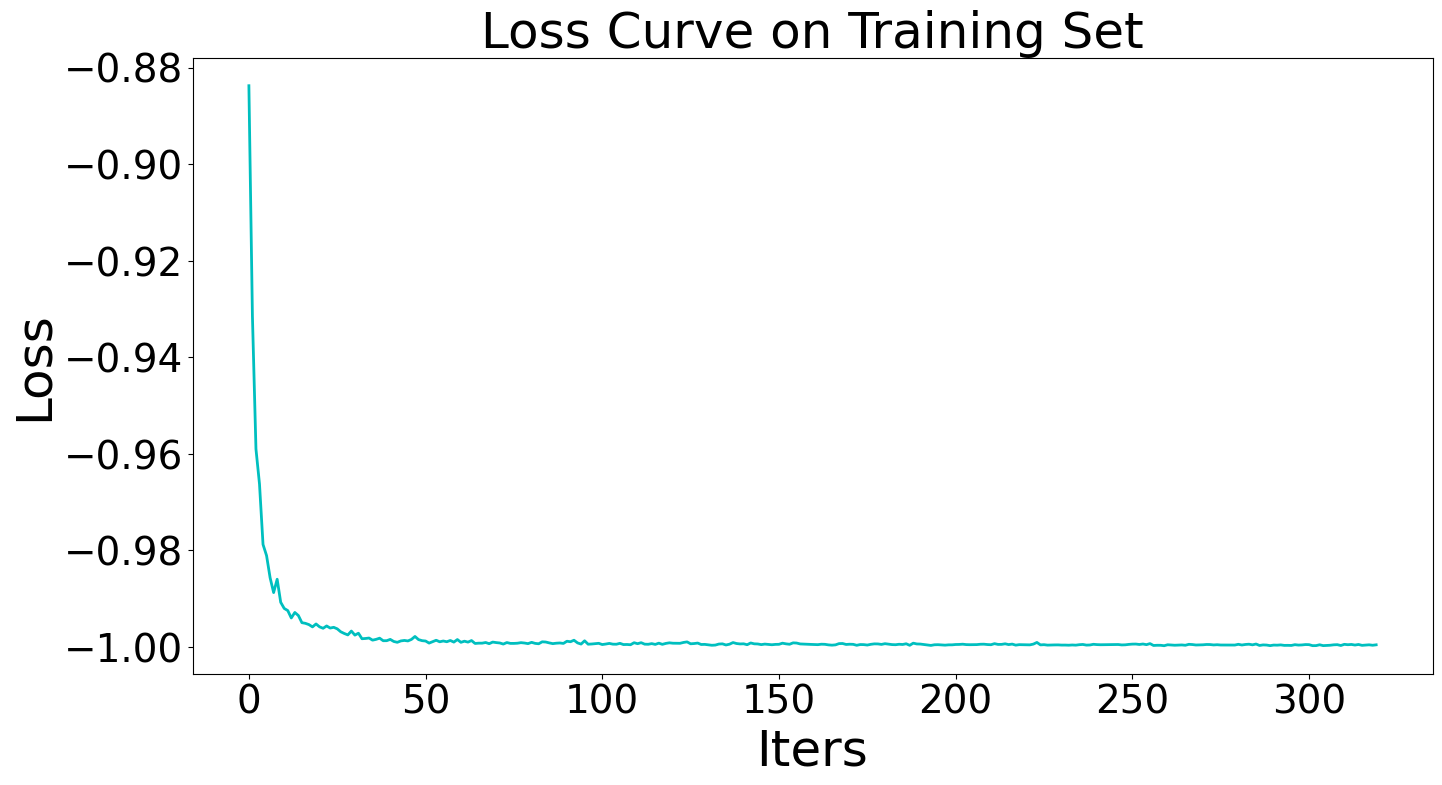

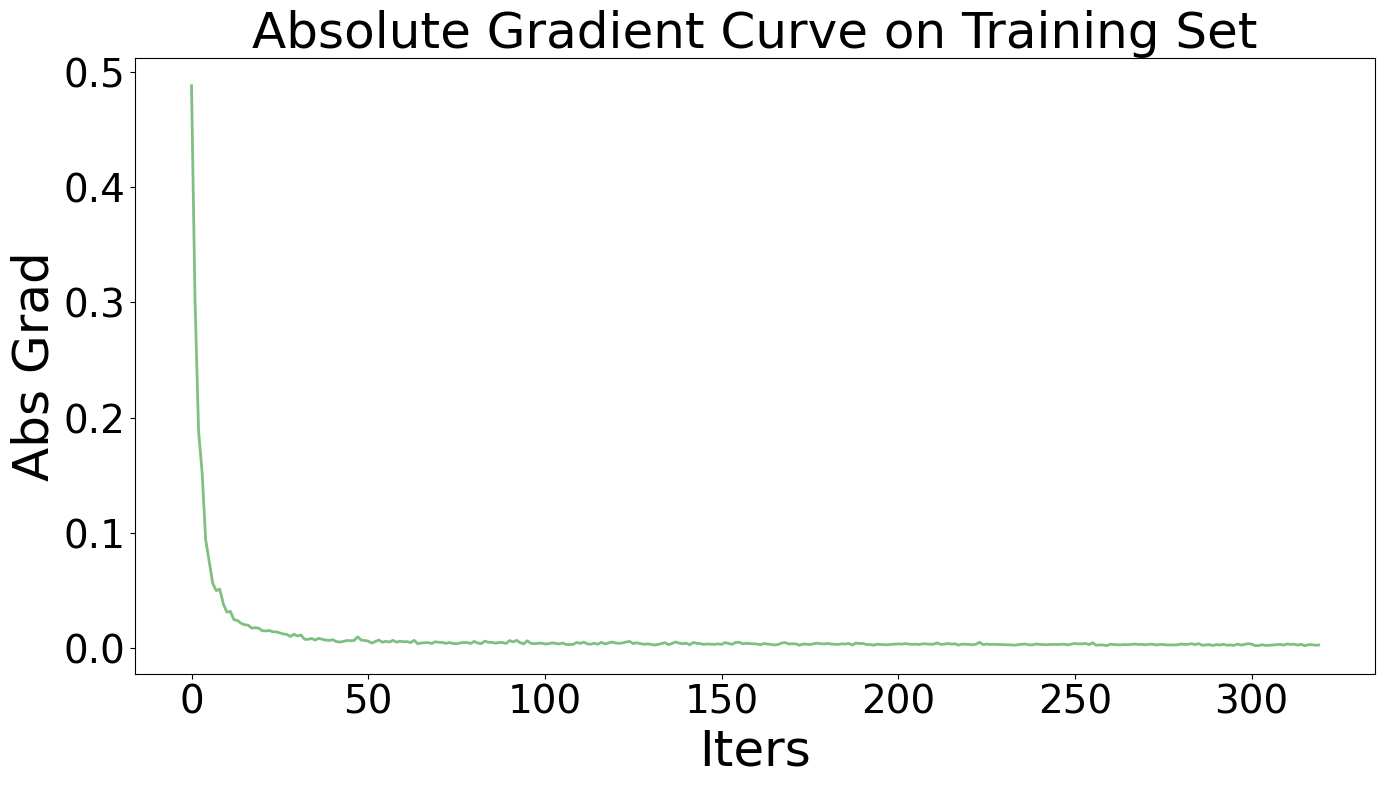

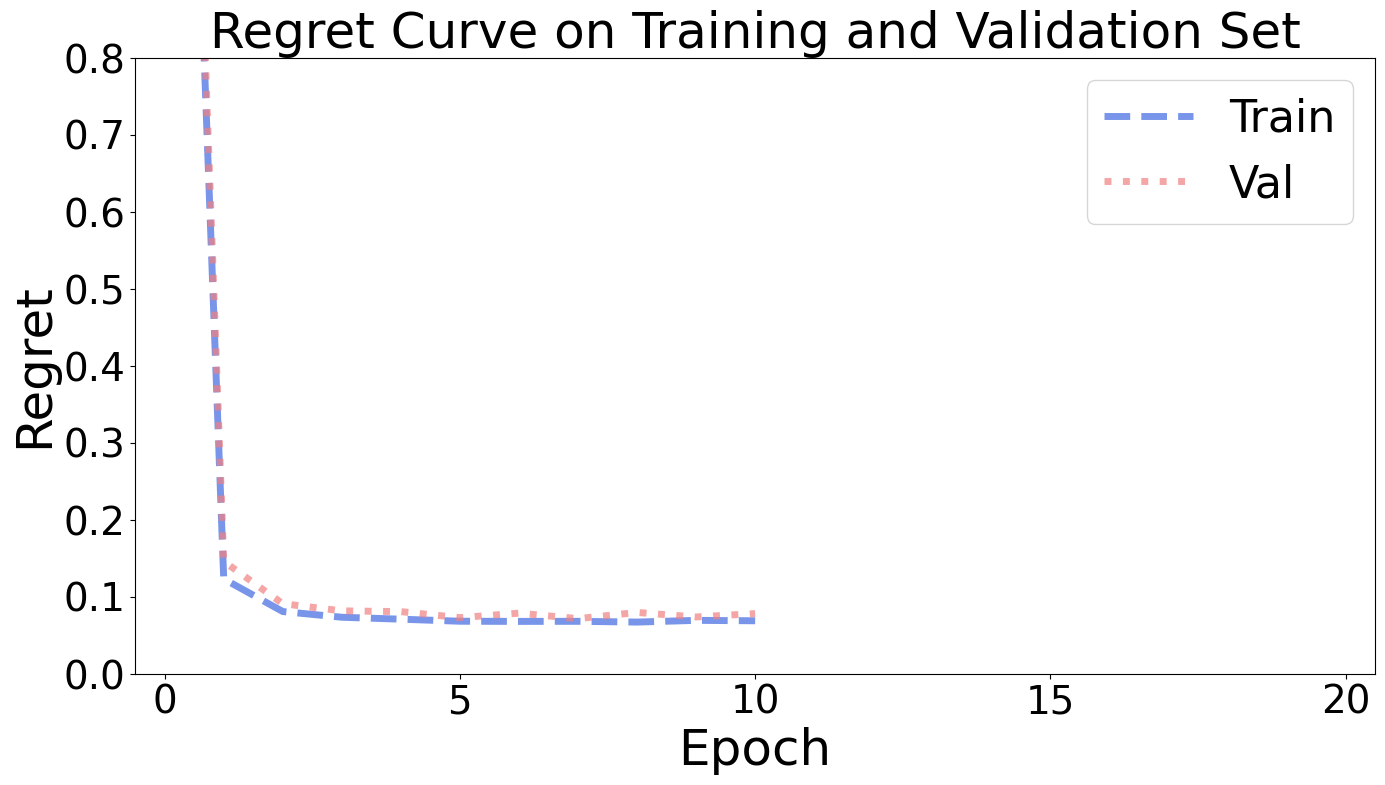

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [16]:
lr = 1e1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret:   6.8057%, Val Regret:   7.1527%


Epoch    0, Loss:  -0.9950:   5%|██▊                                                    | 1/20 [00:23<04:12, 13.30s/it]

Epoch   1, Train Regret:  16.8526%, Val Regret:  18.4277%


Epoch    1, Loss:  -0.9983:  10%|█████▌                                                 | 2/20 [00:38<04:10, 13.91s/it]

Epoch   2, Train Regret:  10.4355%, Val Regret:  11.5925%


Epoch    2, Loss:  -0.9991:  15%|████████▎                                              | 3/20 [00:51<04:50, 17.06s/it]


Epoch   3, Train Regret:   8.4512%, Val Regret:   9.1859%

Early Stop!

Evaluation:
Test Regret: 7.2756%
Training Elapsed Time: 7.94 Sec


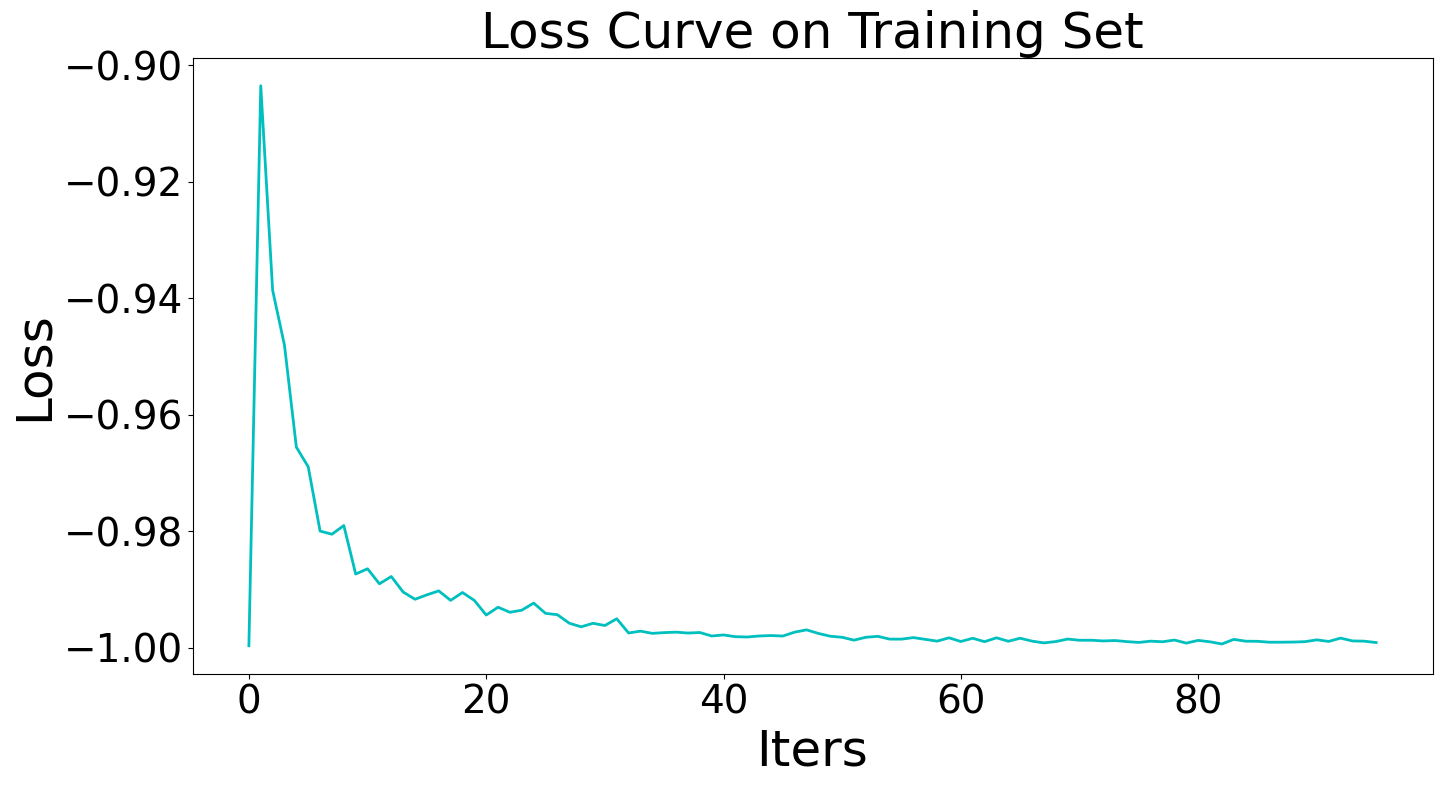

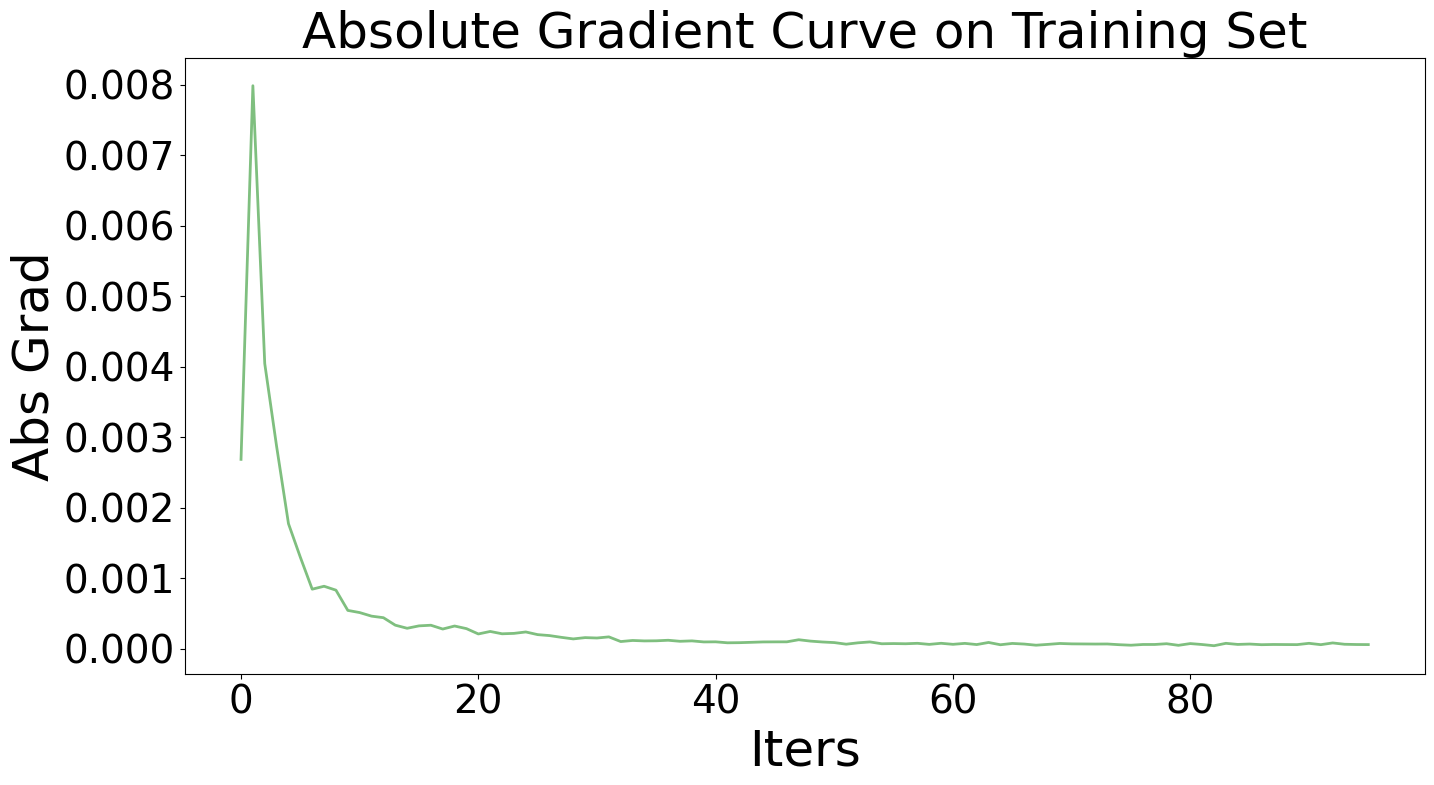

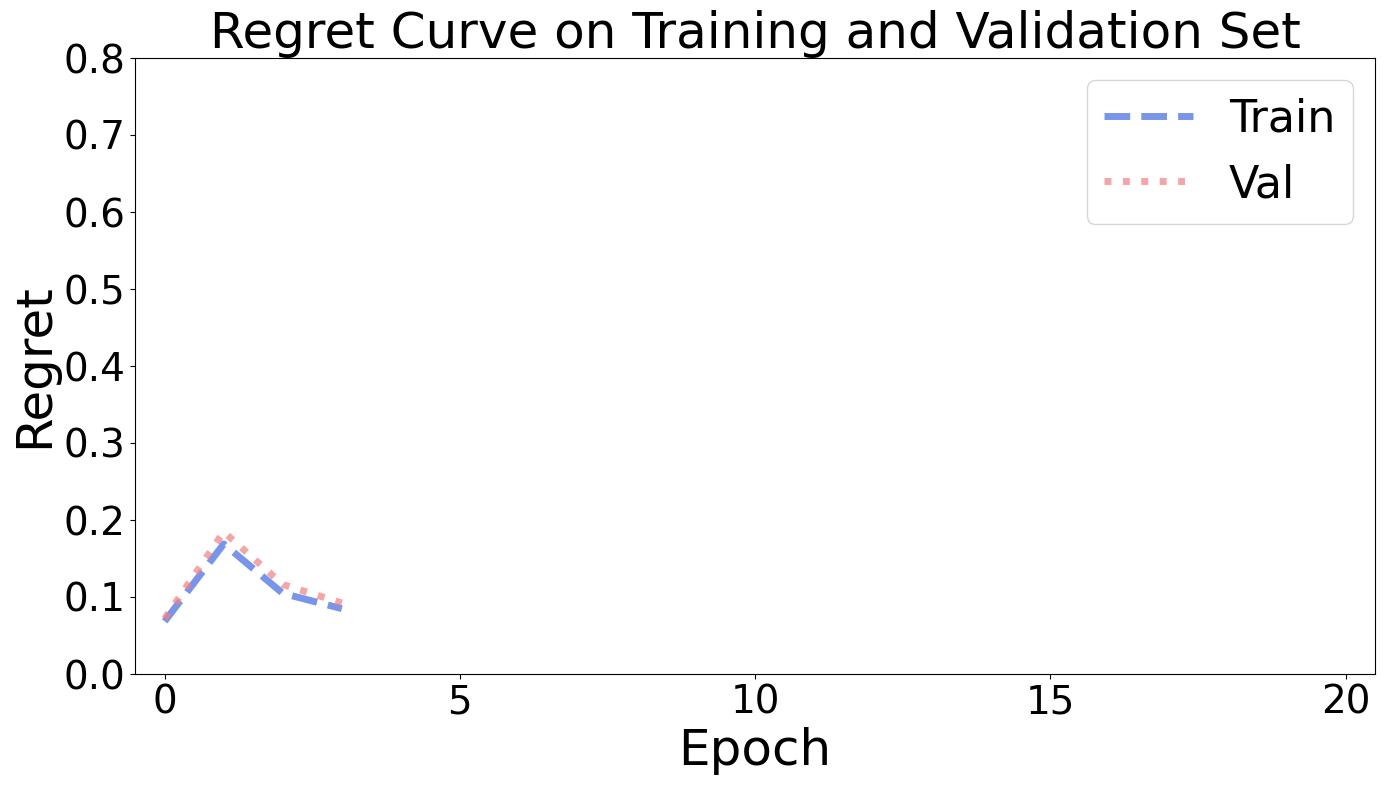

In [17]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Gradient Clip 

In [18]:
# init model
reg = LinearRegression()

In [19]:
def clip_gradients(model, threshold):
    for param in model.parameters():
        if param.grad is not None:
            with torch.no_grad():
                grad = param.grad
                grad[torch.abs(grad) < threshold] = 0

In [20]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            clip_gradients(reg, threshold=1e-6) # clip
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

In [21]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.0045%, Val Regret: 217.3731%


Epoch    0, Loss:  -0.9981:   5%|██▊                                                    | 1/20 [00:22<04:06, 12.99s/it]

Epoch   1, Train Regret:  12.7897%, Val Regret:  13.7097%


Epoch    1, Loss:  -0.9986:  10%|█████▌                                                 | 2/20 [00:35<03:54, 13.01s/it]

Epoch   2, Train Regret:   8.4717%, Val Regret:   9.7231%


Epoch    2, Loss:  -0.9989:  15%|████████▎                                              | 3/20 [00:49<03:43, 13.15s/it]

Epoch   3, Train Regret:   7.5147%, Val Regret:   8.2421%


Epoch    3, Loss:  -0.9994:  20%|███████████                                            | 4/20 [01:02<03:31, 13.19s/it]

Epoch   4, Train Regret:   7.1954%, Val Regret:   8.3183%


Epoch    4, Loss:  -0.9993:  25%|█████████████▊                                         | 5/20 [01:15<03:19, 13.27s/it]

Epoch   5, Train Regret:   6.9257%, Val Regret:   7.7216%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [01:30<03:07, 13.39s/it]

Epoch   6, Train Regret:   7.0413%, Val Regret:   7.5302%


Epoch    6, Loss:  -0.9991:  35%|███████████████████▎                                   | 7/20 [01:43<02:59, 13.84s/it]

Epoch   7, Train Regret:   6.9119%, Val Regret:   7.2224%


Epoch    7, Loss:  -0.9993:  40%|██████████████████████                                 | 8/20 [01:57<02:43, 13.66s/it]

Epoch   8, Train Regret:   6.7877%, Val Regret:   7.1082%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:10<02:28, 13.54s/it]

Epoch   9, Train Regret:   6.5840%, Val Regret:   7.0035%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:23<02:14, 13.42s/it]

Epoch  10, Train Regret:   6.8526%, Val Regret:   6.8269%


Epoch   10, Loss:  -0.9996:  55%|█████████████████████████████▋                        | 11/20 [02:36<01:59, 13.33s/it]

Epoch  11, Train Regret:   6.7526%, Val Regret:   6.8884%


Epoch   11, Loss:  -0.9996:  60%|████████████████████████████████▍                     | 12/20 [02:49<01:46, 13.27s/it]

Epoch  12, Train Regret:   6.6326%, Val Regret:   7.0453%


Epoch   12, Loss:  -0.9996:  65%|███████████████████████████████████                   | 13/20 [03:03<01:38, 14.09s/it]


Epoch  13, Train Regret:   6.7654%, Val Regret:   7.3579%

Early Stop!

Evaluation:
Test Regret: 7.2849%
Training Elapsed Time: 33.86 Sec


In [22]:
lr = 1e1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret:   6.8471%, Val Regret:   6.8269%


Epoch    0, Loss:  -0.9950:   5%|██▊                                                    | 1/20 [00:24<04:17, 13.55s/it]

Epoch   1, Train Regret:  21.3482%, Val Regret:  21.7598%


Epoch    1, Loss:  -0.9975:  10%|█████▌                                                 | 2/20 [00:37<04:12, 14.05s/it]

Epoch   2, Train Regret:  16.3405%, Val Regret:  17.5404%


Epoch    2, Loss:  -0.9983:  15%|████████▎                                              | 3/20 [00:51<04:52, 17.21s/it]


Epoch   3, Train Regret:  15.2367%, Val Regret:  16.3260%

Early Stop!

Evaluation:
Test Regret: 7.2849%
Training Elapsed Time: 7.81 Sec
